In [1]:
# Imports and initialization

import torch
import torch.nn as nn
import numpy as np
from scipy.stats import qmc
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import os
from tqdm import trange
import csv

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_dtype(torch.float64)

plt.rcParams['figure.figsize'] = [6.4, 4.8]
plt.rcParams['figure.dpi'] = 100

seed = 4321
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [2]:
# Problem constants

r_0 = 0.5
beta = np.array([1.0, 5.0])
alpha = 1.0


In [3]:
# Shallow neural networks for PINN

class PINN(nn.Module):

    def __init__(self, in_dim, h_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=h_dim),
            nn.Tanh(),
            nn.Linear(in_features=h_dim, out_features=out_dim, bias=False)
        )

    def forward(self, x):
        out = self.model(x)
        return out


In [4]:
# Loss functions for residual PDE

# u: control
# v: state
# p: adjoint


# State PDE residual loss

def loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, \
                   grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner):
    p_inner_pred = model_p(X_inner)
    u_inner_pred = torch.minimum(U_b_inner, torch.maximum(U_a_inner, -(1.0 / alpha) * h_inner * p_inner_pred))  # Be careful to multiply h_inner
    v_inner_pred = model_v(X_inner)
    dvdX = torch.autograd.grad(
        v_inner_pred, X_inner,
        grad_outputs=torch.ones_like(v_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # v_x v_y v_z
    dvdX_xX = torch.autograd.grad(
        dvdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # v_xx v_xy v_xz
    dvdX_yX = torch.autograd.grad(
        dvdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # v_yx v_yy v_yz
    dvdX_zX = torch.autograd.grad(
        dvdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dvdX[:,2]),
        create_graph=True
        )[0] # v_zx v_zy v_zz
    
    v_xx = dvdX_xX[:,0].reshape(len(dvdX_xX[:,0]), 1)
    v_yy = dvdX_yX[:,1].reshape(len(dvdX_yX[:,1]), 1)
    v_zz = dvdX_zX[:,2].reshape(len(dvdX_zX[:,2]), 1)
    v_xz = dvdX_xX[:,2].reshape(len(dvdX_xX[:,2]), 1)
    v_yz = dvdX_yX[:,2].reshape(len(dvdX_yX[:,2]), 1)
    v_z = dvdX[:,2].reshape(len(dvdX[:,2]), 1)
    v_x = dvdX[:,0].reshape(len(dvdX[:,0]), 1)
    v_y = dvdX[:,1].reshape(len(dvdX[:,1]), 1)

    tilde_v_x = v_x + v_z * grad_z_inner[:,0:1]
    tilde_v_y = v_y + v_z * grad_z_inner[:,1:2]
    tilde_v_xx = v_xx + 2.0 * v_xz * grad_z_inner[:,0:1] + v_zz * (grad_z_inner[:,0:1]**2) + v_z * grad_grad_z_inner[:,0:1]
    tilde_v_yy = v_yy + 2.0 * v_yz * grad_z_inner[:,1:2] + v_zz * (grad_z_inner[:,1:2]**2) + v_z * grad_grad_z_inner[:,1:2]

    laplace = grad_grad_g_inner[:,0:1] + grad_grad_g_inner[:,1:2] \
        + v_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
            2.0 * tilde_v_x * grad_h_inner[:,0:1] + 2.0 * tilde_v_y * grad_h_inner[:,1:2] \
                + h_inner * (tilde_v_xx + tilde_v_yy)

    loss_res = torch.mean((laplace + (u_inner_pred + Rf_inner) / Beta_inner) ** 2)
    return loss_res


# State PDE interface jump loss

def loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, h_ij, grad_h_ij, grad_g_ij_outer, grad_g_ij_inner):

    ij_outer = torch.cat([X_ij[:,0:2], z_ij], dim=1)

    v_ij_outer = model_v(ij_outer)

    vx_ij_outer = torch.autograd.grad(
        v_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(v_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]


    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    tilde_vx_ij_outer_x = vx_ij_outer[:,0:1] + vx_ij_outer[:,2:3] * grad_z_ij_outer[:,0:1]
    tilde_vx_ij_outer_y = vx_ij_outer[:,1:2] + vx_ij_outer[:,2:3] * grad_z_ij_outer[:,1:2]
    Normal_outer = normal_x * (grad_g_ij_outer[:,0:1] + tilde_vx_ij_outer_x * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (grad_g_ij_outer[:,1:2] + tilde_vx_ij_outer_y * h_ij + v_ij_outer * grad_h_ij[:,1:2])

    tilde_vx_ij_inner_x = vx_ij_outer[:,0:1] + vx_ij_outer[:,2:3] * grad_z_ij_inner[:,0:1]
    tilde_vx_ij_inner_y = vx_ij_outer[:,1:2] + vx_ij_outer[:,2:3] * grad_z_ij_inner[:,1:2]
    Normal_inner = normal_x * (grad_g_ij_inner[:,0:1] + tilde_vx_ij_inner_x * h_ij + v_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (grad_g_ij_inner[:,1:2] + tilde_vx_ij_inner_y * h_ij + v_ij_outer * grad_h_ij[:,1:2])

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Vnj_ij)**2)

    return loss_normal_jump


In [5]:
# Loss functions for adjoint PDEs

# Adjoint PDE residual loss

def loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner, \
                 grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, g_inner):

    v_inner_pred = model_v(X_inner)
    p_inner_pred = model_p(X_inner)
    dpdX = torch.autograd.grad(
        p_inner_pred, X_inner,
        grad_outputs=torch.ones_like(p_inner_pred),
        retain_graph=True,
        create_graph=True
        )[0] # p_x p_y
    dpdX_xX = torch.autograd.grad(
        dpdX[:,0], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,0]),
        retain_graph=True,
        create_graph=True
        )[0] # p_xx p_xy p_xz
    dpdX_yX = torch.autograd.grad(
        dpdX[:,1], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,1]),
        retain_graph=True,
        create_graph=True
        )[0] # p_yx p_yy p_yz
    dpdX_zX = torch.autograd.grad(
        dpdX[:,2], X_inner,
        grad_outputs=torch.ones_like(dpdX[:,2]),
        retain_graph=True,
        create_graph=True
        )[0] # p_zx p_zy p_zz
    
    p_xx = dpdX_xX[:,0].reshape(len(dpdX_xX[:,0]), 1)
    p_yy = dpdX_yX[:,1].reshape(len(dpdX_yX[:,1]), 1)
    p_zz = dpdX_zX[:,2].reshape(len(dpdX_zX[:,2]), 1)
    p_xz = dpdX_xX[:,2].reshape(len(dpdX_xX[:,2]), 1)
    p_yz = dpdX_yX[:,2].reshape(len(dpdX_yX[:,2]), 1)
    p_z = dpdX[:,2].reshape(len(dpdX[:,2]), 1)
    p_x = dpdX[:,0].reshape(len(dpdX[:,0]), 1)
    p_y = dpdX[:,1].reshape(len(dpdX[:,1]), 1)

    tilde_p_x = p_x + p_z * grad_z_inner[:,0:1]
    tilde_p_y = p_y + p_z * grad_z_inner[:,1:2]
    tilde_p_xx = p_xx + 2.0 * p_xz * grad_z_inner[:,0:1] + p_zz * (grad_z_inner[:,0:1]**2) + p_z * grad_grad_z_inner[:,0:1]
    tilde_p_yy = p_yy + 2.0 * p_yz * grad_z_inner[:,1:2] + p_zz * (grad_z_inner[:,1:2]**2) + p_z * grad_grad_z_inner[:,1:2]

    laplace = p_inner_pred * (grad_grad_h_inner[:,0:1] + grad_grad_h_inner[:,1:2]) + \
        2.0 * tilde_p_x * grad_h_inner[:,0:1] + 2.0 * tilde_p_y * grad_h_inner[:,1:2] \
            + h_inner * (tilde_p_xx + tilde_p_yy)

    loss_res = torch.mean((laplace + (g_inner + h_inner * v_inner_pred - vd_inner) / Beta_inner) ** 2)
    return loss_res


# Adjoint interface jump loss

def loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, h_ij, grad_h_ij):

    ij_outer = torch.cat([X_ij[:,0:2], z_ij], dim=1)

    u_ij_outer = model_p(ij_outer)

    ux_ij_outer = torch.autograd.grad(
        u_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(u_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    tilde_ux_ij_outer_x = ux_ij_outer[:,0:1] + ux_ij_outer[:,2:3] * grad_z_ij_outer[:,0:1]
    tilde_ux_ij_outer_y = ux_ij_outer[:,1:2] + ux_ij_outer[:,2:3] * grad_z_ij_outer[:,1:2]
    Normal_outer = normal_x * (tilde_ux_ij_outer_x * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (tilde_ux_ij_outer_y * h_ij + u_ij_outer * grad_h_ij[:,1:2])

    tilde_ux_ij_inner_x = ux_ij_outer[:,0:1] + ux_ij_outer[:,2:3] * grad_z_ij_inner[:,0:1]
    tilde_ux_ij_inner_y = ux_ij_outer[:,1:2] + ux_ij_outer[:,2:3] * grad_z_ij_inner[:,1:2]
    Normal_inner = normal_x * (tilde_ux_ij_inner_x * h_ij + u_ij_outer * grad_h_ij[:,0:1]) + \
        normal_y * (tilde_ux_ij_inner_y * h_ij + u_ij_outer * grad_h_ij[:,1:2])    # here u_ij_inner = u_ij_outer

    normal_jump_pred = beta[1] * Normal_outer - beta[0] * Normal_inner
    loss_normal_jump = torch.mean((normal_jump_pred - Pnj_ij)**2)

    return loss_normal_jump


In [6]:
# Total loss function

def loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
         X_ij, Normal_ij, Vnj_ij, Pnj_ij, grad_z_inner, grad_grad_z_inner, z_ij, grad_z_ij_outer, grad_z_ij_inner, 
         g_inner, grad_grad_g_inner, grad_g_ij_outer, grad_g_ij_inner, h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij):
    
    loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, 
                             grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner)
    loss_vij = loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, 
                             h_ij, grad_h_ij, grad_g_ij_outer, grad_g_ij_inner)
    loss_pr = loss_adj_res(model_v, model_p, X_inner, Beta_inner, vd_inner, 
                           grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, g_inner)
    loss_pij = loss_adj_ij(model_p, X_ij, Normal_ij, Pnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, h_ij, grad_h_ij)
    loss_total = loss_vr + loss_vij + 3.0 * loss_pr + loss_pij
    return loss_total, loss_vr, loss_vij, loss_pr, loss_pij


In [7]:
# Problem parameters

# Exact solutions
# Return state, control and adjoint in order

def exact_u(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    phi = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    u = np.minimum(u_b(x, y), np.maximum(u_a(x, y), -(1.0 / alpha) * phi))
    return u

def exact_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    v = np.power(x**2 + y**2, 1.5) / Beta  + (1.0 / beta[0] - 1.0 / beta[1]) * (r_0 ** 3) * (0.5 * (z + 1.0))
    return v

def exact_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    p = -5.0 * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / Beta
    return p

# Normal vectors for points on interface
def normal_vector(x, y):
    dist = np.sqrt(x**2 + y**2)
    normal_x = x / dist
    normal_y = y / dist
    normal = np.hstack((normal_x, normal_y))
    return normal

# Normal derivative of v on the interface
def normal_v(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    temp = 3.0 * np.sqrt(x**2 + y**2) / Beta
    grad_x = temp * x
    grad_y = temp * y
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Normal derivative of p on the interface
def normal_p(x, y, z):
    Beta = 0.5 * beta[0] * (1.0 - z) + 0.5 * beta[1] * (1.0 + z)
    normal = normal_vector(x, y)
    normal_x = normal[:, 0:1]
    normal_y = normal[:, 1:2]
    grad_x = (-5.0 * alpha) * 2.0 * x * (y**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    grad_y = (-5.0 * alpha) * 2.0 * y * (x**2 - 1.0) * (2.0 * x**2 + y**2 - r_0**2 - 1.0) / Beta
    nu = normal_x * grad_x + normal_y * grad_y
    return nu

# Desired state function
def vd(x, y, z):
    v = exact_v(x, y, z)
    laplace_beta_p = (-5.0 * alpha) * (2.0 * (x**4 + y**4 + 12.0 * (x**2) * (y**2)) - (16.0 + 2.0 * (r_0)**2) * (x**2 + y**2) + 4.0 * (r_0**2 + 1.0))
    return v + laplace_beta_p

# Right hand side of state-control PDE
def rhs_f(x, y, z):
    u = exact_u(x, y, z)
    return -9.0 * np.sqrt(x**2 + y**2) - u

# Lower and upper bound for admissible control
def u_a(x, y):
    return 0.0 * x - 1.0

def u_b(x, y):
    return 0.0 * x + 1.0


In [8]:
# Auxiliary functions

# Determine which region does (x, y) belong to
def sign_x(x, y):
    z = 0.0 * x + 1.0
    for i in range(len(z)):
        dist = np.sqrt(x[i]**2 + y[i]**2)
        if dist < r_0:
            z[i] = -1.0
    return z


# Boundary condition
def g_val(x, y):
    return np.power(x**2 * y**2 + 1.0, 1.5) / beta[1]  + (1.0 / beta[0] - 1.0 / beta[1]) * (r_0 ** 3)


# Uniform sampling
def uniform_sampling(dim, n):
    return 2.0 * np.random.rand(n**dim, dim) - 1.0

# Chebyshev points of first kind
def cheb_points(n):
    return np.polynomial.chebyshev.chebpts1(n).reshape(n, 1)


In [9]:
# Initialize training data

# Density of grid points
N_inner = 32

# Sampling training points

# X_inner: points inside the domain, totally (N_inner-1)**2 points
# z: value of auxiliary function phi at a inner training point
# z_sign: the region where a trainin point belongs to
X_inner = uniform_sampling(2, N_inner)
x = X_inner[:, 0:1]
y = X_inner[:, 1:2]
z_sign = sign_x(x, y)
Beta_inner = 0.5 * beta[0] * (1.0 - z_sign) + 0.5 * beta[1] * (1.0 + z_sign)
X_inner = np.hstack((X_inner, z_sign))

# Problem parameters
vd_inner = vd(x, y, z_sign)
Rf_inner = rhs_f(x, y, z_sign)
U_a_inner = u_a(x, y)
U_b_inner = u_b(x, y)

# X_bd: points on the boundary
dumy_one = np.ones((2 * N_inner,1))
lh_point = cheb_points(2 * N_inner)
xx1 = np.hstack((lh_point, -1.0*dumy_one, dumy_one))
lh_point = cheb_points(2 * N_inner)
xx2 = np.hstack((-1.0*dumy_one, lh_point, dumy_one))
lh_point = cheb_points(2 * N_inner)
xx3 = np.hstack((dumy_one, lh_point, dumy_one))
lh_point = cheb_points(2 * N_inner)
xx4 = np.hstack((lh_point, dumy_one, dumy_one))
X_bd = np.vstack([xx1, xx2, xx3, xx4])

# Value of auxiliary functions g, h on inner training points
g_bd = g_val(X_bd[:,0:1], X_bd[:,1:2])
h_bd = 0.0 * X_bd[:,0:1]

# X_ij: points on the interior interface, totally 8*N_inner points
# z_ij: auxiliary function values on interface
theta = 2.0 * np.pi * np.random.rand(8 * N_inner, 1)
x_ij = 0.5 * np.cos(theta)
y_ij = 0.5 * np.sin(theta)
X_ij = np.hstack([x_ij, y_ij])

# Unit normal vector on the interface
Normal_ij = normal_vector(x_ij, y_ij)

# Vnj_ij: state function normal jump on the interior interface
Vnj_ij = beta[1] * normal_v(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_v(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Pnj_ij: adjoint function normal jump on the interior interface
Pnj_ij = beta[1] * normal_p(x_ij, y_ij, 0.0 * x_ij + 1.0) - beta[0] * normal_p(x_ij, y_ij, 0.0 * x_ij - 1.0)

# Value of auxiliary functions g, h on interface
g_ij = 0.0 * X_ij


In [10]:
# Convert numpy arrays to tensors and pass to training device

X_inner = torch.from_numpy(X_inner).requires_grad_(True).double().to(device)
vd_inner = torch.from_numpy(vd_inner).double().to(device)
Rf_inner = torch.from_numpy(Rf_inner).double().to(device)
U_a_inner = torch.from_numpy(U_a_inner).double().to(device)
U_b_inner = torch.from_numpy(U_b_inner).double().to(device)
Beta_inner = torch.from_numpy(Beta_inner).double().to(device)

X_bd = torch.from_numpy(X_bd).double().to(device)

g_bd = torch.from_numpy(g_bd).double().to(device)
h_bd = torch.from_numpy(h_bd).double().to(device)

X_ij = torch.from_numpy(X_ij).requires_grad_(True).double().to(device)
Normal_ij = torch.from_numpy(Normal_ij).double().to(device)
Vnj_ij = torch.from_numpy(Vnj_ij).double().to(device)
Pnj_ij = torch.from_numpy(Pnj_ij).double().to(device)

g_ij = torch.from_numpy(g_ij).double().to(device)


In [11]:
# Construct neural networks for approximating auxiliary functions

model_g = PINN(2, 500, 1).to(device)
model_h = PINN(2, 500, 1).to(device)
model_z = PINN(3, 200, 1).to(device)

h_inner = torch.cos(0.5 * np.pi * X_inner[:,0:1].detach()) * torch.cos(0.5 * np.pi * X_inner[:,1:2].detach())

grad_z_ij_inner = 0.0 * X_ij[:,0:1].detach() + 5.0
grad_z_ij_outer = 0.0 * X_ij[:,0:1].detach() + 0.0

def loss_g(model_g, X_bd, X_ij, g_bd, g_ij):

    loss_g_bd = torch.mean((model_g(X_bd) - g_bd) ** 2)
    loss_g_val = loss_g_bd

    return loss_g_val


def loss_h(model_h, X_inner, X_bd, h_inner, h_bd):
    
        h_inner_pred = model_h(X_inner)
        h_bd_pred = model_h(X_bd)
    
        loss_h_inner = torch.mean((h_inner_pred - h_inner) ** 2)
        loss_h_bd = torch.mean((h_bd_pred - h_bd) ** 2)
        loss_h_val = loss_h_bd + 0.01 * loss_h_inner
    
        return loss_h_val, loss_h_inner, loss_h_bd


def loss_z(model_z, X_ij, grad_z_ij_outer, grad_z_ij_inner):

    ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)
    ij_inner = torch.cat([X_ij[:,0:2], -1.0+0.0*X_ij[:,0:1]], dim=1)

    z_ij_outer = model_z(ij_outer)

    zx_ij_outer = torch.autograd.grad(
        z_ij_outer, ij_outer,
        grad_outputs=torch.ones_like(z_ij_outer),
        retain_graph=True,
        create_graph=True
    )[0]

    normal_x = Normal_ij[:, 0:1]
    normal_y = Normal_ij[:, 1:2]
    Normal_outer = normal_x * zx_ij_outer[:,0:1] + normal_y * zx_ij_outer[:,1:2]

    z_ij_inner = model_z(ij_inner)

    zx_ij_inner = torch.autograd.grad(
        z_ij_inner, ij_inner,
        grad_outputs=torch.ones_like(z_ij_inner),
        retain_graph=True,
        create_graph=True
    )[0]

    Normal_inner = normal_x * zx_ij_inner[:,0:1] + normal_y * zx_ij_inner[:,1:2]

    jump_pred = z_ij_outer - z_ij_inner
    loss_jump = torch.mean((jump_pred)**2)
    loss_normal_jump = torch.mean((Normal_outer - grad_z_ij_outer)**2 + (Normal_inner - grad_z_ij_inner)**2)
    loss_z = loss_jump + loss_normal_jump

    return loss_z, loss_jump, loss_normal_jump


In [12]:
# Train auxiliary function g

optimizer_g = torch.optim.LBFGS(list(model_g.parameters()), tolerance_grad=1e-12, tolerance_change=1e-12, line_search_fn='strong_wolfe')
max_iter_g = 300

pbar = trange(max_iter_g)

for step in pbar:

    def closure_g():
        optimizer_g.zero_grad()
        loss_g_val = loss_g(model_g, X_bd[:,0:2], X_ij, g_bd, g_ij)
        loss_g_val.backward()
        return loss_g_val

    loss_g_val = loss_g(model_g, X_bd[:,0:2], X_ij, g_bd, g_ij)
    optimizer_g.step(closure_g)

    # if step % 100 == 0:
    pbar.set_postfix({'loss_g': '{0:.5e}'.format(loss_g_val.item()),
                          'stepsize': '{0:.5e}'.format(optimizer_g.param_groups[0]['lr'])})


100%|██████████| 300/300 [00:12<00:00, 24.98it/s, loss_g=3.20167e-07, stepsize=1.00000e+00]


In [13]:
# Train auxiliary function h

optimizer_h = torch.optim.LBFGS(list(model_h.parameters()), tolerance_grad=1e-12, tolerance_change=1e-12, line_search_fn='strong_wolfe')
max_iter_h = 200

pbar = trange(max_iter_h)

for step in pbar:

    def closure_h():
        optimizer_h.zero_grad()
        loss_h_val, loss_h_inner, loss_h_bd = loss_h(model_h, X_inner[:,0:2], X_bd[:,0:2], h_inner, h_bd)
        loss_h_val.backward()
        return loss_h_val

    loss_h_val, loss_h_inner, loss_h_bd = loss_h(model_h, X_inner[:,0:2], X_bd[:,0:2], h_inner, h_bd)
    optimizer_h.step(closure_h)

    # if step % 100 == 0:
    pbar.set_postfix({'loss_h': '{0:.5e}'.format(loss_h_val.item()),
                          'loss_h_inner': '{0:.5e}'.format(loss_h_inner.item()),
                          'loss_h_bd': '{0:.5e}'.format(loss_h_bd.item()),
                          'stepsize': '{0:.5e}'.format(optimizer_h.param_groups[0]['lr'])})


100%|██████████| 200/200 [01:48<00:00,  1.84it/s, loss_h=6.34875e-07, loss_h_inner=4.35378e-05, loss_h_bd=1.99496e-07, stepsize=1.00000e+00]


In [14]:
# Train auxiliary function z (i.e. phi)

optimizer_z = torch.optim.Adam(list(model_z.parameters()), lr=5e-4)
max_iter_z = 30000

pbar = trange(max_iter_z)

for step in pbar:
    if step == 10000:
        for g in optimizer_z.param_groups:
            g['lr'] = 0.0002
    if step == 20000:
        for g in optimizer_z.param_groups:
            g['lr'] = 0.0001

    optimizer_z.zero_grad()
    loss_z_val, loss_z_inner, loss_z_bd = loss_z(model_z, X_ij, grad_z_ij_outer, grad_z_ij_inner)
    loss_z_val.backward()
    optimizer_z.step()

    if step % 100 == 0:
        pbar.set_postfix({'loss_z': '{0:.5e}'.format(loss_z_val.item()),
                          'loss_z_inner': '{0:.5e}'.format(loss_z_inner.item()),
                          'loss_z_bd': '{0:.5e}'.format(loss_z_bd.item()),
                          'stepsize': '{0:.5e}'.format(optimizer_z.param_groups[0]['lr'])})



100%|██████████| 30000/30000 [01:39<00:00, 302.05it/s, loss_z=5.12430e-07, loss_z_inner=1.20502e-07, loss_z_bd=3.91928e-07, stepsize=1.00000e-04]


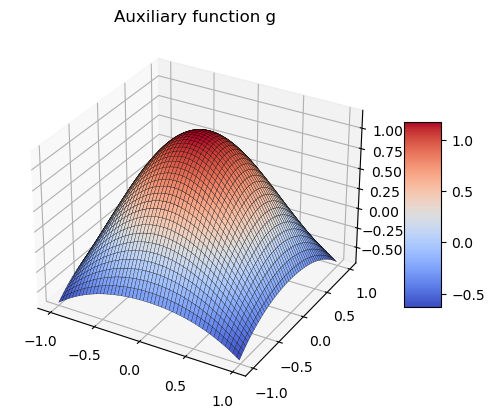

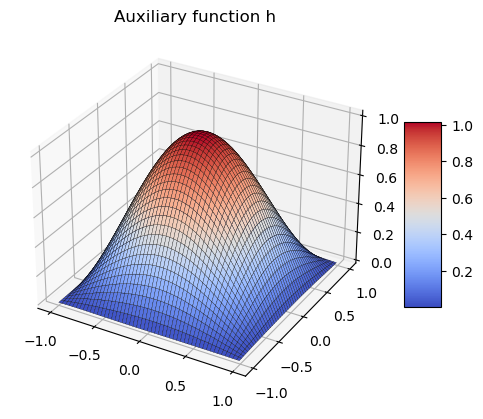

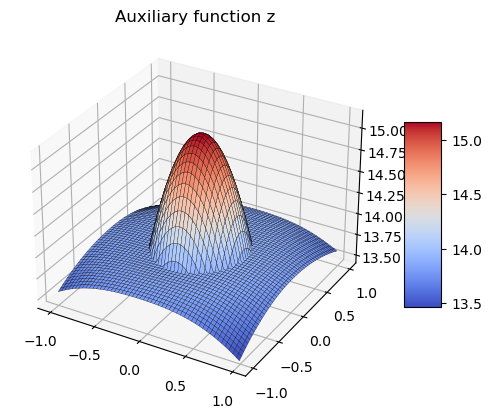

In [15]:
# Plot auxiliary functions

xlist = ylist = np.arange(-1, 1, 0.01)
x_mesh, y_mesh = np.meshgrid(xlist, ylist)

z_plot = 0.0 * x_mesh + 1.0
sign_plot = 0.0 * x_mesh + 1.0
for i in range(len(z_plot)):
    for j in range(len(z_plot[i])):
        dist = np.sqrt(x_mesh[i, j]**2 + y_mesh[i, j]**2)
        if dist < r_0:
            z_plot[i, j] = 4.0 * (dist**2)
            sign_plot[i, j] = -1.0

# Reshaping data for neural network processing
x_mesh_r = x_mesh.reshape(40000)
y_mesh_r = y_mesh.reshape(40000)
sign_plot_r = sign_plot.reshape(40000)
data_plot = np.stack((x_mesh_r, y_mesh_r, sign_plot_r), axis=-1)
data_plot_torch = torch.tensor(data_plot).double().to(device)
g_val_plot = model_g(data_plot_torch[:, 0:2]).detach().cpu().numpy()
h_val_plot = model_h(data_plot_torch[:, 0:2]).detach().cpu().numpy()
z_val_plot = model_z(data_plot_torch).detach().cpu().numpy()
g_val_plot = g_val_plot.reshape(200, 200)
h_val_plot = h_val_plot.reshape(200, 200)
z_val_plot = z_val_plot.reshape(200, 200)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_g_val = ax.plot_surface(x_mesh, y_mesh, -g_val_plot, cmap=cm.coolwarm, linewidth=0.2)
surf_g_val.set_edgecolors("black")
ax.title.set_text('Auxiliary function g')
fig.colorbar(surf_g_val, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_h_val = ax.plot_surface(x_mesh, y_mesh, h_val_plot, cmap=cm.coolwarm, linewidth=0.2)
surf_h_val.set_edgecolors("black")
ax.title.set_text('Auxiliary function h')
fig.colorbar(surf_h_val, shrink=0.5, aspect=5)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_z_val = ax.plot_surface(x_mesh, y_mesh, -z_val_plot, cmap=cm.coolwarm, linewidth=0.2)
surf_z_val.set_edgecolors("black")
ax.title.set_text('Auxiliary function z')
fig.colorbar(surf_z_val, shrink=0.5, aspect=5)
plt.show()


In [16]:
# Store the gradient info, avoid repeated computation

X_ij_outer = torch.cat([X_ij[:,0:2], 1.0+0.0*X_ij[:,0:1]], dim=1)
X_ij_inner = torch.cat([X_ij[:,0:2], -1.0+0.0*X_ij[:,0:1]], dim=1)

g_inner = model_g(X_inner[:,0:2])
grad_g_inner = torch.autograd.grad(
    g_inner, X_inner,
    grad_outputs=torch.ones_like(g_inner),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_g_inner_xX = torch.autograd.grad(
    grad_g_inner[:,0], X_inner,
    grad_outputs=torch.ones_like(grad_g_inner[:,0]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_g_inner_yX = torch.autograd.grad(
    grad_g_inner[:,1], X_inner,
    grad_outputs=torch.ones_like(grad_g_inner[:,1]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_grad_g_inner = torch.hstack((grad_g_inner_xX[:,0:1], grad_g_inner_yX[:,1:2]))

g_ij_outer = model_g(X_ij)
grad_g_ij_outer = torch.autograd.grad(
    g_ij_outer, X_ij,
    grad_outputs=torch.ones_like(g_ij_outer),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
g_ij_inner = model_g(X_ij)
grad_g_ij_inner = torch.autograd.grad(
    g_ij_inner, X_ij,
    grad_outputs=torch.ones_like(g_ij_inner),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]

h_inner = model_h(X_inner[:,0:2])
grad_h_inner = torch.autograd.grad(
    h_inner, X_inner,
    grad_outputs=torch.ones_like(h_inner),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_h_inner_xX = torch.autograd.grad(
    grad_h_inner[:,0], X_inner,
    grad_outputs=torch.ones_like(grad_h_inner[:,0]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_h_inner_yX = torch.autograd.grad(
    grad_h_inner[:,1], X_inner,
    grad_outputs=torch.ones_like(grad_h_inner[:,1]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_grad_h_inner = torch.hstack((grad_h_inner_xX[:,0:1], grad_h_inner_yX[:,1:2]))
h_ij = model_h(X_ij)
grad_h_ij = torch.autograd.grad(
    h_ij, X_ij,
    grad_outputs=torch.ones_like(h_ij),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]

# X_inner_flip = torch.hstack((X_inner[:,0:2], -X_inner[:,2:3]))
z_inner = model_z(X_inner)
grad_z_inner = torch.autograd.grad(
    z_inner, X_inner,
    grad_outputs=torch.ones_like(model_z(X_inner)),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_z_inner_xX = torch.autograd.grad(
    grad_z_inner[:,0], X_inner,
    grad_outputs=torch.ones_like(grad_z_inner[:,0]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_z_inner_yX = torch.autograd.grad(
    grad_z_inner[:,1], X_inner,
    grad_outputs=torch.ones_like(grad_z_inner[:,1]),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
grad_grad_z_inner = torch.hstack((grad_z_inner_xX[:,0:1], grad_z_inner_yX[:,1:2]))

z_ij_outer = model_z(X_ij_outer)
grad_z_ij_outer = torch.autograd.grad(
    z_ij_outer, X_ij_outer,
    grad_outputs=torch.ones_like(z_ij_outer),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
z_ij_inner = model_z(X_ij_inner)
grad_z_ij_inner = torch.autograd.grad(
    z_ij_inner, X_ij_inner,
    grad_outputs=torch.ones_like(z_ij_inner),
    retain_graph=True,
    create_graph=True
)[0][:,0:2]
z_ij = 0.5 * (z_ij_outer + z_ij_inner)

g_inner = g_inner.detach()
grad_g_inner = grad_g_inner.detach()
grad_grad_g_inner = grad_grad_g_inner.detach()
g_ij_outer = g_ij_outer.detach()
grad_g_ij_outer = grad_g_ij_outer.detach()
g_ij_inner = g_ij_inner.detach()
grad_g_ij_inner = grad_g_ij_inner.detach()
h_inner = h_inner.detach()
grad_h_inner = grad_h_inner.detach()
grad_grad_h_inner = grad_grad_h_inner.detach()
h_ij = h_ij.detach()
grad_h_ij = grad_h_ij.detach()
z_inner = z_inner.detach()
grad_z_inner = grad_z_inner.detach()
grad_grad_z_inner = grad_grad_z_inner.detach()
z_ij_outer = z_ij_outer.detach()
grad_z_ij_outer = grad_z_ij_outer.detach()
z_ij_inner = z_ij_inner.detach()
grad_z_ij_inner = grad_z_ij_inner.detach()
z_ij = z_ij.detach()

X_inner = torch.hstack((X_inner[:,0:2].detach(), z_inner)).requires_grad_(True).double().to(device)


In [17]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [18]:
# Model, optimizer and learning rates

# PINN model
model_v = PINN(3, 100, 1).to(device)
model_p = PINN(3, 100, 1).to(device)
print(model_v)
print(model_p)

optimizer = torch.optim.Adam(
    list(model_v.parameters()) + list(model_p.parameters()), 
    lr=0.005)
max_iter = 60000

def lr_adjust(step, optimizer: torch.optim.Adam):
    update_lr_1 = 5000
    update_lr_2 = 10000
    update_lr_3 = 20000
    update_lr_4 = 30000

    if step == update_lr_1:
        for g in optimizer.param_groups:
            g['lr'] = 0.002
    if step == update_lr_2:
        for g in optimizer.param_groups:
            g['lr'] = 0.001
    if step == update_lr_3:
        for g in optimizer.param_groups:
            g['lr'] = 0.0005
    if step == update_lr_4:
        for g in optimizer.param_groups:
            g['lr'] = 0.0003


PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)
PINN(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=1, bias=False)
  )
)


In [19]:
# Training loop

model_v.train()
model_p.train()

loss_hist = []
pbar = trange(max_iter)

for step in pbar:

    lr_adjust(step, optimizer)

    # Backward and optimize
    optimizer.zero_grad()
    loss_total, loss_vr, loss_vij, loss_pr, loss_pij = \
        loss(model_v, model_p, X_inner, Beta_inner, Rf_inner, vd_inner, U_a_inner, U_b_inner, 
             X_ij, Normal_ij, Vnj_ij, Pnj_ij, grad_z_inner, grad_grad_z_inner, z_ij, grad_z_ij_outer, grad_z_ij_inner, 
             g_inner, grad_grad_g_inner, grad_g_ij_outer, grad_g_ij_inner, h_inner, grad_h_inner, grad_grad_h_inner, h_ij, grad_h_ij)
    loss_total.backward()
    optimizer.step()

    if step % 100 == 0:
        pbar.set_postfix({'loss': '{0:.5e}'.format(loss_total.item()),
                          'loss_vr': '{0:.5e}'.format(loss_vr.item()),
                          'loss_vij': '{0:.5e}'.format(loss_vij.item()),
                          'loss_pr': '{0:.5e}'.format(loss_pr.item()),
                          'loss_pij': '{0:.5e}'.format(loss_pij.item()),
                          'stepsize': '{0:.5e}'.format(optimizer.param_groups[0]['lr'])})
        loss_hist.append(loss_total.item())


100%|██████████| 60000/60000 [16:54<00:00, 59.17it/s, loss=9.73600e-04, loss_vr=6.02566e-04, loss_vij=9.74053e-06, loss_pr=1.17790e-04, loss_pij=7.92357e-06, stepsize=3.00000e-04]


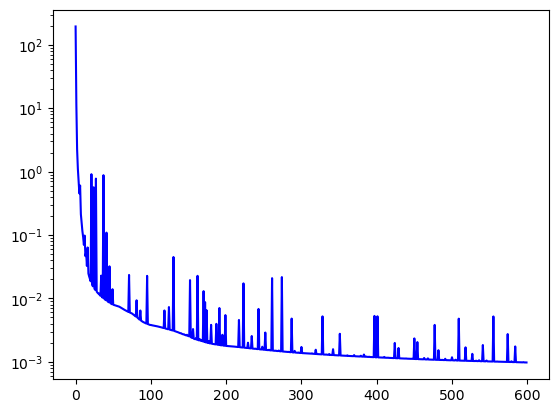

In [20]:
fig, ax = plt.subplots()
ax.plot(loss_hist, 'b')
ax.set_yscale('log')
plt.show()

In [21]:
# Further training for state variable with fixed control

optimizer_g = torch.optim.LBFGS(
    model_v.parameters(), tolerance_grad=1e-12, tolerance_change=1e-12, line_search_fn='strong_wolfe')
max_iter = 300

pbar = trange(max_iter)

for step in pbar:

    # Backward and optimize
    def closure():
        optimizer_g.zero_grad()
        loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, 
                             grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner)
        loss_vij = loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, 
                             h_ij, grad_h_ij, grad_g_ij_outer, grad_g_ij_inner)
        loss_total = loss_vr + loss_vij
        loss_total.backward()
        return loss_total

    loss_vr = loss_state_res(model_p, model_v, X_inner, Beta_inner, Rf_inner, U_a_inner, U_b_inner, 
                             grad_z_inner, grad_grad_z_inner, h_inner, grad_h_inner, grad_grad_h_inner, grad_grad_g_inner)
    loss_vij = loss_state_ij(model_v, X_ij, Normal_ij, Vnj_ij, z_ij, grad_z_ij_outer, grad_z_ij_inner, 
                             h_ij, grad_h_ij, grad_g_ij_outer, grad_g_ij_inner)
    loss_total = loss_vr + loss_vij
    optimizer_g.step(closure)

    # if step % 100 == 0:
    pbar.set_postfix({'loss': '{0:.5e}'.format(loss_total.item()),
                          'loss_vr': '{0:.5e}'.format(loss_vr.item()),
                          'loss_vij': '{0:.5e}'.format(loss_vij.item()),
                          'stepsize': '{0:.5e}'.format(optimizer.param_groups[0]['lr'])})

100%|██████████| 300/300 [03:54<00:00,  1.28it/s, loss=3.58042e-04, loss_vr=3.55352e-04, loss_vij=2.69040e-06, stepsize=3.00000e-04]


In [22]:
# Testing trained model on uniform grid
# Here, all the L^2 averaged errors are multiplied by 2 to account for the square root of the domain area

for N_test in [16, 32, 64, 128, 256]:

    print('Testing on %d x %d uniform grid' % (N_test, N_test))

    # Absolute error

    xlist = ylist = np.linspace(-1, 1, N_test)
    x_mesh, y_mesh = np.meshgrid(xlist, ylist)
    X_inner_test = np.hstack((x_mesh.reshape(-1, 1), y_mesh.reshape(-1, 1)))
    x_test = X_inner_test[:, 0:1]
    y_test = X_inner_test[:, 1:2]
    sign_test = sign_x(x_test, y_test)
    X_inner_test_sign = torch.tensor(np.hstack((X_inner_test, sign_test))).double().to(device)
    z_test = model_z(X_inner_test_sign).detach().cpu().numpy()
    h_test = model_h(X_inner_test_sign[:, 0:2]).detach().cpu().numpy()
    g_test = model_g(X_inner_test_sign[:, 0:2]).detach().cpu().numpy()
    u_a_test = u_a(x_test, y_test)
    u_b_test = u_b(x_test, y_test)
    u_exact = exact_u(x_test, y_test, sign_test)
    p_exact = exact_p(x_test, y_test, sign_test)
    v_exact = exact_v(x_test, y_test, sign_test)
    X_inner_test = np.hstack((X_inner_test, z_test))
    X_inner_test_torch = torch.tensor(X_inner_test).double().to(device).requires_grad_(True)

    with torch.no_grad():
        p_pred_torch = model_p(X_inner_test_torch)
        p_pred = h_test * p_pred_torch.detach().cpu().numpy()
        u_pred = np.minimum(u_b_test, np.maximum(u_a_test, -(1.0/alpha) * p_pred))
        v_pred_torch = model_v(X_inner_test_torch)
        v_pred = g_test + h_test * v_pred_torch.detach().cpu().numpy()

    error_u = 2.0 * np.linalg.norm(np.absolute(u_pred - u_exact), 2)/N_test
    error_v = 2.0 * np.linalg.norm(np.absolute(v_pred - v_exact), 2)/N_test
    error_p = 2.0 * np.linalg.norm(np.absolute(p_pred - p_exact), 2)/N_test
    print('Error u (absolute 2-norm): %e' % (error_u))
    print('Error y (absolute 2-norm): %e' % (error_v))
    print('Error p (absolute 2-norm): %e' % (error_p))

    # Relative error

    def eu_minus_polar(r, theta):
        val = 5.0 * (1.0 / alpha) * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[0]
        return r * (val)**2 if np.abs(val) < 1 else r

    def eu_plus_polar(r, theta):
        val = 5.0 * (1.0 / alpha)  * (r**2 - r_0**2) * (r**2 * np.cos(theta)**2 - 1.0) * (r**2 * np.sin(theta)**2 - 1.0) / beta[1]
        return r * val**2 if np.abs(val) < 1 else r

    def eu_plus_cart(x, y):
        val = 5.0 * (1.0 / alpha)  * (x**2 + y**2 - r_0**2) * (x**2 - 1.0) * (y**2 - 1.0) / beta[1]
        return val**2 if np.abs(val) < 1 else 1

    norm_eu_minus_inner_squared = integrate.dblquad(eu_minus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
    norm_eu_plus_whole_squared = integrate.dblquad(eu_plus_cart, -1.0, 1.0, -1.0, 1.0)
    norm_eu_plus_inner_squared = integrate.dblquad(eu_plus_polar, 0.0, 2.0 * np.pi, 0.0, r_0)
    norm_eu_plus_outer_squared = norm_eu_plus_whole_squared[0] - norm_eu_plus_inner_squared[0]
    norm_eu = np.sqrt((norm_eu_minus_inner_squared[0] + norm_eu_plus_outer_squared) / 4.0) # Normalized by area

    error_rel_u = error_u / norm_eu
    print('Error u (relative 2-norm): %e' % (error_rel_u))


Testing on 16 x 16 uniform grid
Error u (absolute 2-norm): 9.424195e-04
Error y (absolute 2-norm): 7.986736e-04
Error p (absolute 2-norm): 9.431656e-04
Error u (relative 2-norm): 3.077226e-03
Testing on 32 x 32 uniform grid
Error u (absolute 2-norm): 7.816116e-04
Error y (absolute 2-norm): 6.888624e-04
Error p (absolute 2-norm): 7.836564e-04
Error u (relative 2-norm): 2.552149e-03
Testing on 64 x 64 uniform grid
Error u (absolute 2-norm): 7.171437e-04
Error y (absolute 2-norm): 6.450085e-04
Error p (absolute 2-norm): 7.192841e-04
Error u (relative 2-norm): 2.341646e-03
Testing on 128 x 128 uniform grid
Error u (absolute 2-norm): 6.893383e-04
Error y (absolute 2-norm): 6.258362e-04
Error p (absolute 2-norm): 6.917508e-04
Error u (relative 2-norm): 2.250855e-03
Testing on 256 x 256 uniform grid
Error u (absolute 2-norm): 6.764493e-04
Error y (absolute 2-norm): 6.169632e-04
Error p (absolute 2-norm): 6.789053e-04
Error u (relative 2-norm): 2.208769e-03


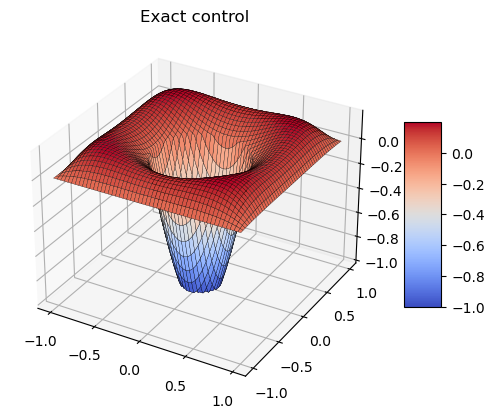

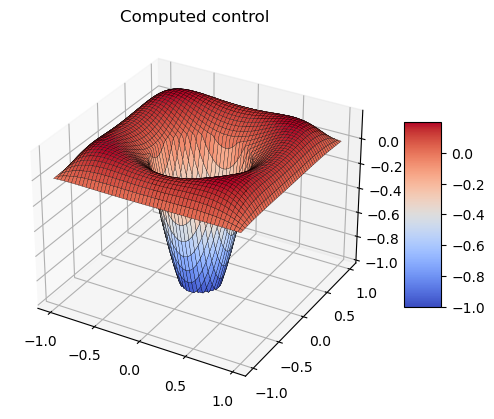

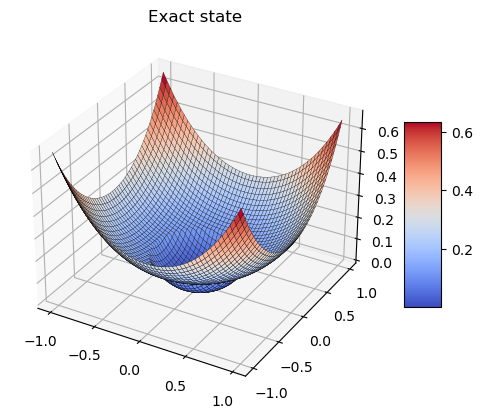

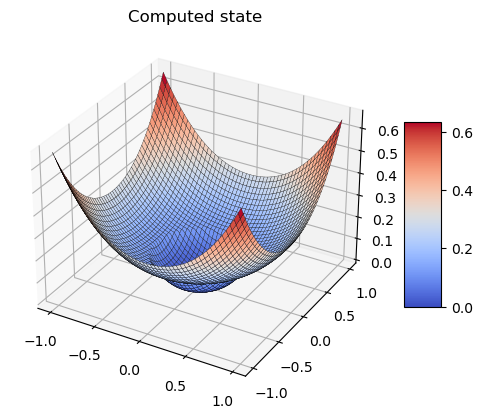

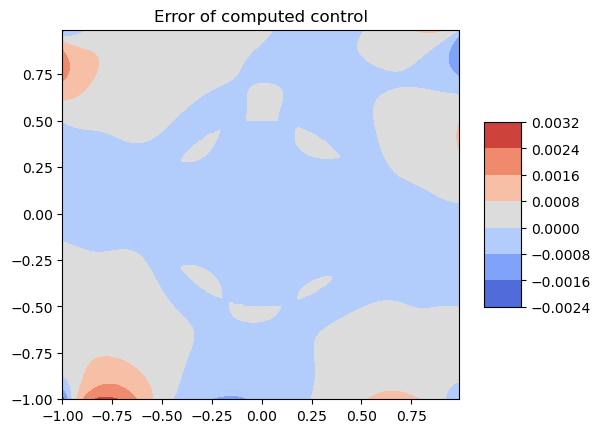

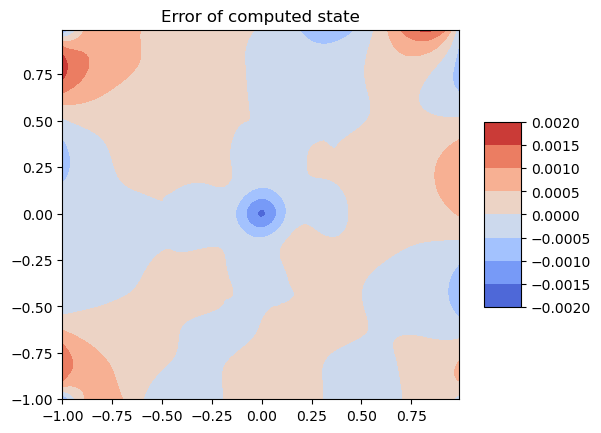

In [23]:
# Plot the solution

xlist = ylist = np.arange(-1, 1, 0.01)
x_mesh, y_mesh = np.meshgrid(xlist, ylist)

z_plot = 0.0 * x_mesh + 1.0
sign_plot = 0.0 * x_mesh + 1.0
for i in range(len(z_plot)):
    for j in range(len(z_plot[i])):
        dist = np.sqrt(x_mesh[i, j]**2 + y_mesh[i, j]**2)
        if dist < r_0:
            sign_plot[i, j] = -1.0

eu = exact_u(x_mesh, y_mesh, sign_plot)
ev = exact_v(x_mesh, y_mesh, sign_plot)
data_plot_sign_r = torch.tensor(np.stack((x_mesh.reshape(40000), y_mesh.reshape(40000), sign_plot.reshape(40000)), axis=-1)).double().to(device)
h_plot_r = model_h(data_plot_sign_r[:,0:2]).detach().cpu().numpy()
g_plot_r = model_g(data_plot_sign_r[:,0:2]).detach().cpu().numpy()
z_plot_r = model_z(data_plot_sign_r).detach().cpu().numpy()
u_a_plot = u_a(x_mesh, y_mesh)
u_b_plot = u_b(x_mesh, y_mesh)

# Reshaping data for neural network processing
x_mesh_r = x_mesh.reshape(40000)
y_mesh_r = y_mesh.reshape(40000)
u_a_plot_r = u_a_plot.reshape(40000, 1)
u_b_plot_r = u_b_plot.reshape(40000, 1)
data_plot = np.stack((x_mesh_r, y_mesh_r, z_plot_r.reshape(40000)), axis=-1)
data_plot_torch = torch.tensor(data_plot).double().to(device)
pp = model_p(data_plot_torch).detach().cpu().numpy()
pv = model_v(data_plot_torch).detach().cpu().numpy()
pp = h_plot_r * pp
pv = g_plot_r + h_plot_r * pv
pu = np.minimum(u_b_plot_r, np.maximum(u_a_plot_r, -(1.0/alpha) * pp))
pu = pu.reshape(200, 200)
pv = pv.reshape(200, 200)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_eu = ax.plot_surface(x_mesh, y_mesh, eu, cmap=cm.coolwarm, linewidth=0.2)
surf_eu.set_edgecolors("black")
ax.title.set_text('Exact control')
fig.colorbar(surf_eu, shrink=0.5, aspect=5)
plt.show()
# plt.savefig('results/ex2-alg2n-exact-u-beta-5.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pu = ax.plot_surface(x_mesh, y_mesh, pu, cmap=cm.coolwarm, linewidth=0.2)
surf_pu.set_edgecolors("black")
ax.title.set_text('Computed control')
fig.colorbar(surf_pu, shrink=0.5, aspect=5)
plt.show()
# plt.savefig('results/ex2-alg2n-computed-u-beta-5.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_ev = ax.plot_surface(x_mesh, y_mesh, ev, cmap=cm.coolwarm, linewidth=0.2)
surf_ev.set_edgecolors("black")
ax.title.set_text('Exact state')
fig.colorbar(surf_ev, shrink=0.5, aspect=5)
plt.show()
# plt.savefig('results/ex2-alg2n-exact-y-beta-5.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf_pv = ax.plot_surface(x_mesh, y_mesh, pv, cmap=cm.coolwarm, linewidth=0.2)
surf_pv.set_edgecolors("black")
ax.title.set_text('Computed state')
fig.colorbar(surf_pv, shrink=0.5, aspect=5)
plt.show()
# plt.savefig('results/ex2-alg2n-computed-y-beta-5.pdf')

fig, ax = plt.subplots()
surf_u_diff = ax.contourf(x_mesh, y_mesh, pu - eu, cmap=cm.coolwarm)
fig.colorbar(surf_u_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed control')
plt.show()
# plt.savefig('results/ex2-alg2n-u-error-beta-5.pdf')

fig, ax = plt.subplots()
surf_v_diff = ax.contourf(x_mesh, y_mesh, pv - ev, cmap=cm.coolwarm)
fig.colorbar(surf_v_diff, shrink=0.5, aspect=5)
ax.title.set_text('Error of computed state')
plt.show()
# plt.savefig('results/ex2-alg2n-y-error-beta-5.pdf')


In [24]:
# Save model, loss log and data set

# model_filename = "results/ex2_alg2n_trained_model_beta_5.pt"
# torch.save({"model_g_state_dict": model_g.state_dict(),
#             "model_h_state_dict": model_h.state_dict(),
#             "model_z_state_dict": model_z.state_dict(),
#             "model_v_state_dict": model_v.state_dict(),
#             "model_p_state_dict": model_p.state_dict(),
#             "optimizer_g_state_dict": optimizer_g.state_dict(),
#             "optimizer_h_state_dict": optimizer_h.state_dict(),
#             "optimizer_z_state_dict": optimizer_z.state_dict(),
#             "optimizer_state_dict": optimizer.state_dict()}, model_filename)

# csvfile = open("results/ex2_alg2n_loss_hist_beta_5.csv", 'w')
# writer = csv.writer(csvfile)
# writer.writerow(loss_hist)
# csvfile.close()

# data_filename_train = "results/ex2_alg2n_data_train_beta_5.npz"
# np.savez(data_filename_train, X_inner=X_inner.cpu().detach().numpy(), X_ij=X_ij.cpu().detach().numpy())

# data_filename_test = "results/ex2_alg2n_data_test_beta_5.npz"
# np.savez(data_filename_test, X_inner_test=X_inner_test)
